# 3D Convolutions for track finding

In this notebook we try 3D convolution instead of LSTM for classifying pixels, etc.

The detector is, as before, composed of square 2D layers.
I generate straight tracks that pass through every layer and leave hits deterministically.

In [1]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import keras.backend as K
from keras.regularizers import l2

# Local imports
from metrics import calc_hit_accuracy
from toydata import generate_data, track_hit_coords
from drawing import draw_layers, draw_projections, draw_train_history

# Magic
%matplotlib notebook

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 4007)


In [2]:
# Set random seed
np.random.seed(2017)

## Data generation

In [3]:
# Configuration
num_det_layers = 10
det_layer_size = 32
num_seed_layers = 3
avg_bkg_tracks = 3
noise_prob = 0.01
det_shape = (num_det_layers, det_layer_size, det_layer_size)

In [4]:
def batch_generator(num_batch, det_shape=det_shape,
                    num_seed_layers=num_seed_layers,
                    avg_bkg_tracks=avg_bkg_tracks,
                    noise_prob=noise_prob):
    """Generator of toy data batches for training"""
    shape = (num_batch,) + det_shape
    while True:
        events, sig_tracks, _ = generate_data(
            shape, num_seed_layers=num_seed_layers,
            avg_bkg_tracks=avg_bkg_tracks,
            noise_prob=noise_prob, verbose=False)
        train_target = sig_tracks.reshape(num_batch, det_shape[0], -1)
        yield (events, train_target)

## Define the model

In [5]:
def build_conv_model(shape, dropout=0, l2reg=0, pool=(1,2,2)):
    """Build the CNN model"""
    inputs = layers.Input(shape=shape)

    # Need a 'channel' dimension for 3D convolution, though we have only 1 channel
    hidden = layers.Reshape((1,)+shape)(inputs)

    # 3D convolutional layers
    conv_args = dict(border_mode='same', activation='relu')
    hidden = layers.Conv3D(8, 3, 3, 3, **conv_args)(hidden)
    hidden = layers.Conv3D(8, 3, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling3D(pool_size=pool)(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Conv3D(16, 3, 3, 3, **conv_args)(hidden)
    hidden = layers.Conv3D(16, 3, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling3D(pool_size=pool)(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Conv3D(32, 3, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling3D(pool_size=pool)(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Conv3D(64, 3, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling3D(pool_size=pool)(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Conv3D(96, 3, 2, 2, **conv_args)(hidden)
    hidden = layers.MaxPooling3D(pool_size=pool)(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Conv3D(128, 3, 1, 1, **conv_args)(hidden)
    # Permute dimensions to group detector layers:
    # (channels, det_layers, w, w) -> (det_layers, channels, w, w)
    PermuteLayer = layers.Permute((2, 1, 3, 4))
    hidden = PermuteLayer(hidden)
    # Reshape to flatten each detector layer: (det_layers, -1)
    perm_shape = PermuteLayer.output_shape
    flat_shape = (perm_shape[1], np.prod(perm_shape[2:]))
    hidden = layers.Reshape(flat_shape, name='flatten')(hidden)
    # Output softmax
    outputs = layers.TimeDistributed(
        layers.Dense(shape[1]*shape[2], activation='softmax',
                     W_regularizer=l2(l2reg)),
        name='output_softmax')(hidden)
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='Nadam', metrics=['accuracy'])
    return model

## Training

In [6]:
l2reg = 0.
dropout = 0.

In [7]:
model = build_conv_model(det_shape, l2reg=l2reg, dropout=dropout)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10, 32, 32)    0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 1, 10, 32, 32) 0           input_1[0][0]                    
____________________________________________________________________________________________________
convolution3d_1 (Convolution3D)  (None, 8, 10, 32, 32) 224         reshape_1[0][0]                  
____________________________________________________________________________________________________
convolution3d_2 (Convolution3D)  (None, 8, 10, 32, 32) 1736        convolution3d_1[0][0]            
___________________________________________________________________________________________

In [8]:
batch_size = 64
num_event = 1600000
events_per_epoch = 32000
num_epoch = num_event / events_per_epoch

In [9]:
history = model.fit_generator(batch_generator(batch_size),
                              samples_per_epoch=events_per_epoch,
                              nb_epoch=num_epoch)

Epoch 1/50
32000/32000 [==============================] - 80s - loss: 5.2031 - acc: 0.0544    
Epoch 2/50
32000/32000 [==============================] - 80s - loss: 2.5793 - acc: 0.2882    
Epoch 3/50
32000/32000 [==============================] - 80s - loss: 1.8780 - acc: 0.4486    
Epoch 4/50
32000/32000 [==============================] - 80s - loss: 1.5888 - acc: 0.5246    
Epoch 5/50
32000/32000 [==============================] - 80s - loss: 1.4490 - acc: 0.5654    
Epoch 6/50
32000/32000 [==============================] - 80s - loss: 1.3516 - acc: 0.5899    
Epoch 7/50
32000/32000 [==============================] - 80s - loss: 1.2714 - acc: 0.6129    
Epoch 8/50
32000/32000 [==============================] - 80s - loss: 1.2273 - acc: 0.6254    
Epoch 9/50
32000/32000 [==============================] - 80s - loss: 1.1820 - acc: 0.6392    
Epoch 10/50
32000/32000 [==============================] - 80s - loss: 1.1493 - acc: 0.6471    
Epoch 11/50
32000/32000 [========================

<IPython.core.display.Javascript object>


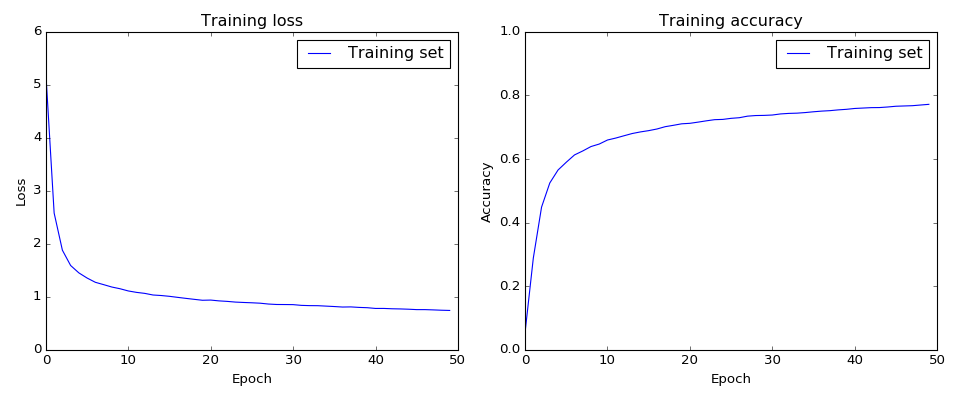

In [10]:
draw_train_history(history, draw_val=False)

## Evaluate results

In [11]:
# Generate a new test dataset
test_num_event = 51200
test_events, test_sigtrks, test_sigparams = generate_data(
    (test_num_event,) + det_shape, num_seed_layers=num_seed_layers,
    avg_bkg_tracks=avg_bkg_tracks, noise_prob=noise_prob)
test_target = test_sigtrks.reshape(test_num_event, num_det_layers, -1)

Sizes of arrays
  events:     2097.15 MB
  sig_tracks: 2097.15 MB
  bkg_tracks: 2097.15 MB
  noise:      524.288 MB
  sig_params: 1.6384 MB


In [12]:
# Run the model on the test set
test_preds = model.predict(test_events, batch_size=batch_size)

In [13]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test_preds, test_target,
                                   num_seed_layers=num_seed_layers)
# Hit classification accuracy
test_scores = test_preds * test_events.reshape(test_num_event, num_det_layers, -1)
hit_accuracy = calc_hit_accuracy(test_scores, test_target)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Accuracy of predicted pixel: 0.6775474330357143
Accuracy of classified hit:  0.968951171875


Input data example event:


<IPython.core.display.Javascript object>


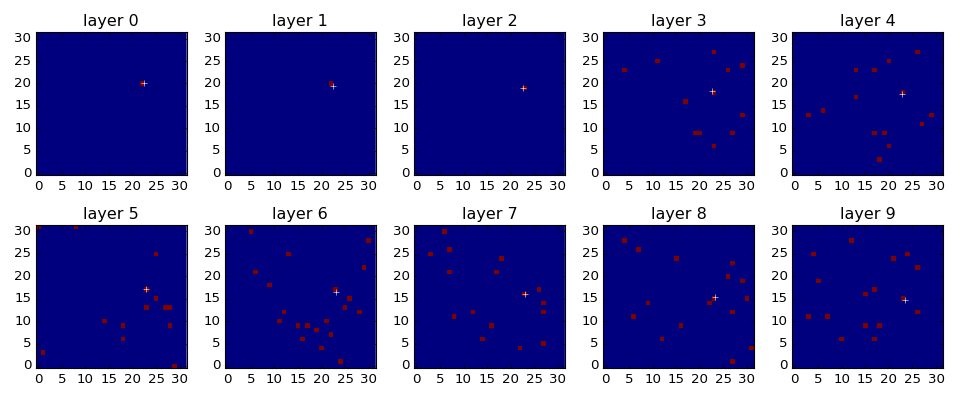

Model prediction:


<IPython.core.display.Javascript object>


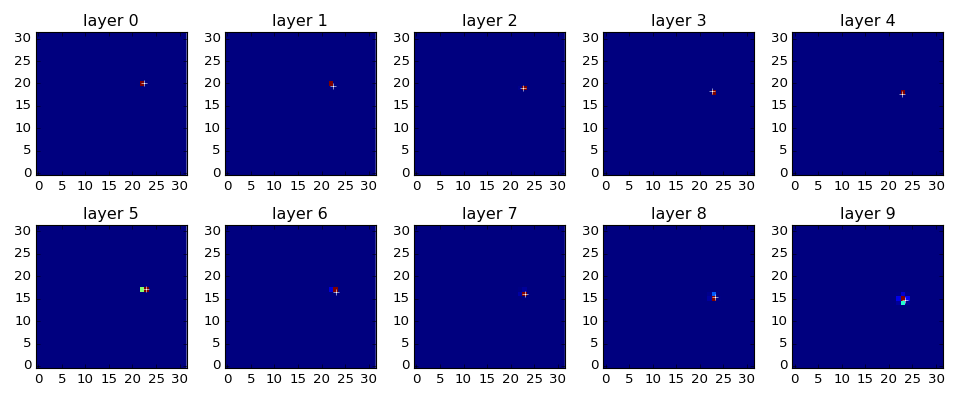

Projected input data:


<IPython.core.display.Javascript object>


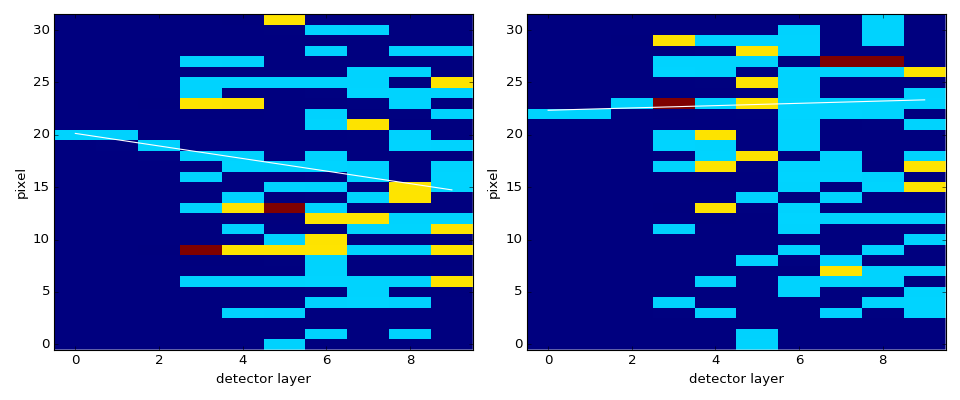

Projected model prediction:


<IPython.core.display.Javascript object>


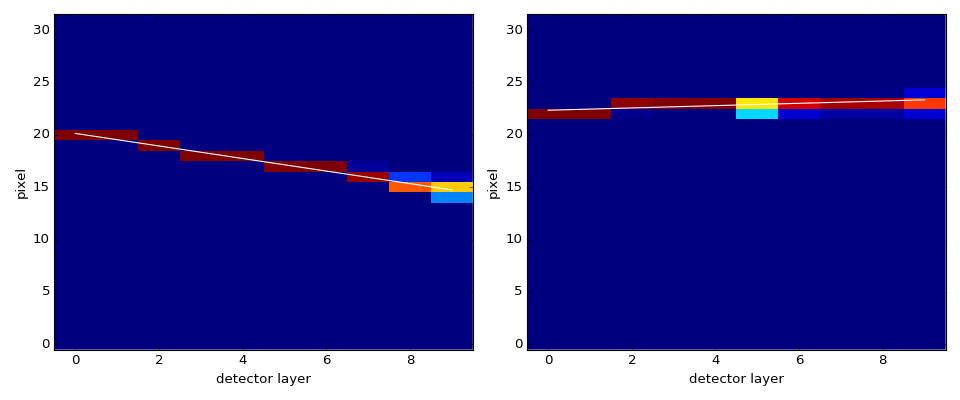

In [14]:
# Select an event to visualize
disp_idx = 1

# Get the hit coordinates for drawing
idx = np.arange(num_det_layers)
xtruth, ytruth = track_hit_coords(test_sigparams[disp_idx],
                                  idx, as_type=np.float32)

# Draw the layers
print('Input data example event:')
draw_layers(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
print('Model prediction:')
draw_layers(test_preds[disp_idx].reshape(det_shape),
            truthx=xtruth, truthy=ytruth)
print('Projected input data:')
draw_projections(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
print('Projected model prediction:')
draw_projections(test_preds[disp_idx].reshape(det_shape),
                 truthx=xtruth, truthy=ytruth)